# Introduction

In [78]:
NAME = '2. nlp and analysis' ## Name of the notebook goes here (without the file extension!)
PROJECT = 'before trilogy'
PYTHON_VERSION = '3.6'

# Preamble

### Imports 

In [79]:
import os, re, math, time
import requests, zipfile, io, os
from tqdm.notebook import tqdm

In [80]:
import requests
import requests_html
import lxml.html

In [81]:
import pandas as pd 
import numpy as np

In [82]:
import spacy
import en_core_web_md
nlp = en_core_web_md.load()

In [83]:
import nltk
from nltk.corpus import words

In [84]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [85]:
# nrc sentiment method
from nrclex import NRCLex
# textblob sentiment method
from textblob import TextBlob

In [86]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [87]:
import string
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [88]:
from PIL import Image

In [89]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Enable multiple cell outputs
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

### Set working directory  

In [90]:
workdir = re.sub("(?<={})[\w\W]*".format(PROJECT), "", os.getcwd())
os.chdir(workdir)

--- 
# Main code

In [91]:
# import the dataframe for analyses
sunrise = pd.read_excel('2_pipeline\sunrise_for_analysis.xlsx')
sunset = pd.read_excel('2_pipeline\sunset_for_analysis.xlsx')
midnight = pd.read_excel('2_pipeline\midnight_for_analysis.xlsx')

## 1. Word cloud

In [92]:
sunrise['movie'] = 'sunrise'
sunset['movie'] = 'sunset'
midnight['movie'] = 'midnight'

In [93]:
three_movies = pd.concat([sunrise, sunset, midnight])
three_movies = three_movies[(three_movies.speaker == 'jesse') | (three_movies.speaker == 'celine')]

In [94]:
# create a list of movies
movies = three_movies.movie.unique()
#create a list of text for each movie
corpus = [' '.join(three_movies[(three_movies.movie==movie)].text.tolist()) for movie in movies]

In [95]:
len(corpus)

3

In [96]:
def process_text(text):
    # remove the non-english words and numbers
    words = set(nltk.corpus.words.words())
    english_text = " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words)
    
    # remove stop words using spacy dictionary
    en = spacy.load('en_core_web_sm')
    stopwords = en.Defaults.stop_words
    clean_text = " ".join(token for token in english_text.split() if token not in stopwords)
    
    return clean_text

In [97]:
corpus_clean = []

for element in corpus:
    corpus_clean.append(process_text(element))

In [98]:
#instantiate a CountVectorizer object
cv=CountVectorizer(strip_accents='unicode',
                   lowercase = True,
                   stop_words='english',
                   max_df=2, # remove words that appear in all three movies. I want to capture the unique words cloud for each movie
                   min_df=0.0)

# fit transform our text and create a dataframe with the result
Y = cv.fit_transform(corpus_clean)
Y = Y.toarray()

bow=pd.DataFrame(Y, columns = cv.get_feature_names())
bow.index=movies

In [99]:
# take a look how the words list look at
tmp = bow.T
tmp['sum_count'] = tmp.sum(axis=1)
tmp.sort_values('sum_count', ascending=False)[0:10]

,sunrise,sunset,midnight,sum_count
hate,20,4,0,24
job,0,3,18,21
henry,0,4,12,16
felt,0,8,6,14
meet,4,9,0,13
money,10,0,3,13
wife,0,5,7,12
definitely,0,9,2,11
turn,8,0,3,11
knew,9,0,2,11


In [100]:
bow = tmp.T

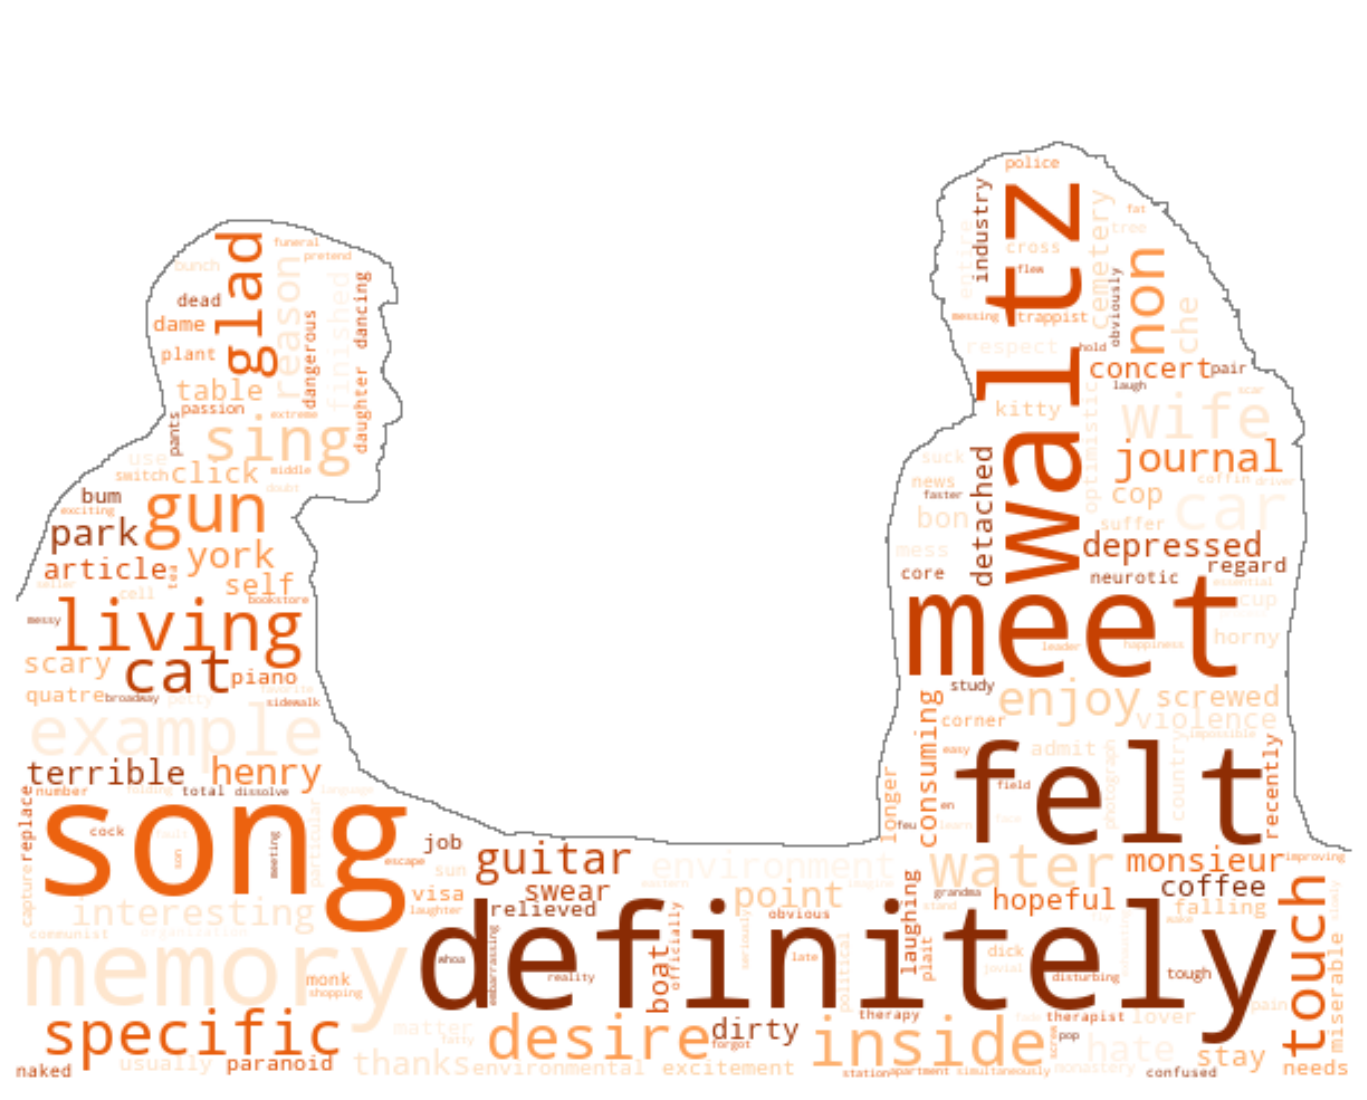

In [101]:
scene = 'sunset'

# create a pandas Series of the most frequent words
text=bow.loc[scene].sort_values(ascending=False)
text_analyze=bow.loc[scene].sort_values(ascending=False).to_dict()

# open the image and use np.array to transform the file to an array
sunset_mask=np.array(Image.open('0_data\\before_sunset.png'))

# create and generate our wordcloud object
wordcloud = WordCloud(min_word_length=1,
                      background_color='white',
                      contour_color='grey',
                      mask=sunset_mask, 
                      colormap='Oranges',
                      contour_width=1).generate_from_frequencies(text_analyze)

# plot
fig, ax = plt.subplots(figsize = (12, 12), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [102]:
fig.savefig('3_output\wordcloud_sunset_upload.png', bbox_inches='tight')

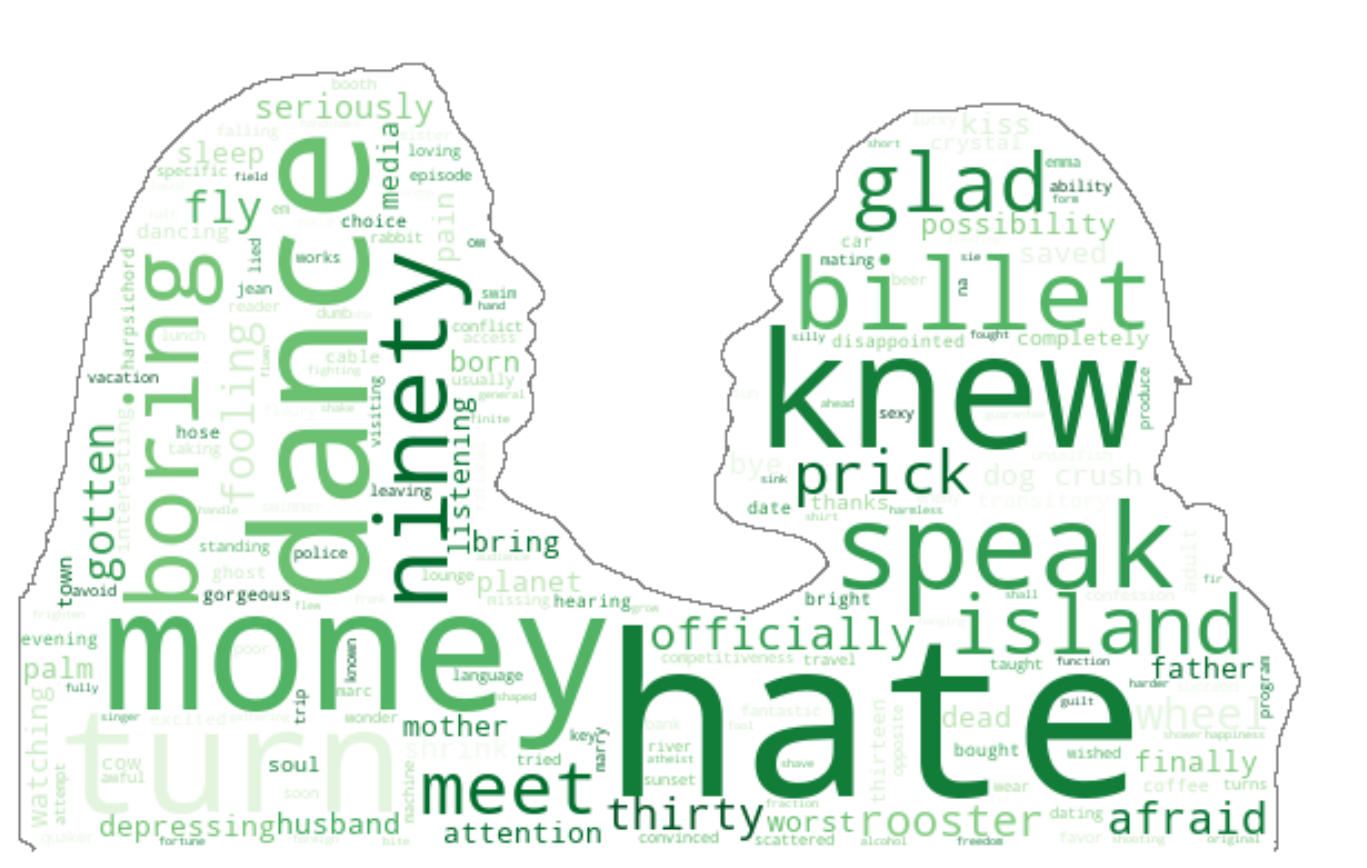

In [103]:
scene = 'sunrise'

# create a pandas Series of the most frequent words
text=bow.loc[scene].sort_values(ascending=False)
text_analyze=bow.loc[scene].sort_values(ascending=False).to_dict()

# open the image and use np.array to transform the file to an array
mask=np.array(Image.open('0_data\\before_sunrise.png'))

#create and generate our wordcloud object
wordcloud = WordCloud(min_word_length=1,
                      background_color='white',
                      contour_color='gray',
                      mask=mask, 
                      colormap='Greens',
                      contour_width=1).generate_from_frequencies(text_analyze)


#plot
fig, ax = plt.subplots(figsize = (12, 12), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [104]:
fig.savefig('3_output\wordcloud_sunrise.png', bbox_inches='tight')

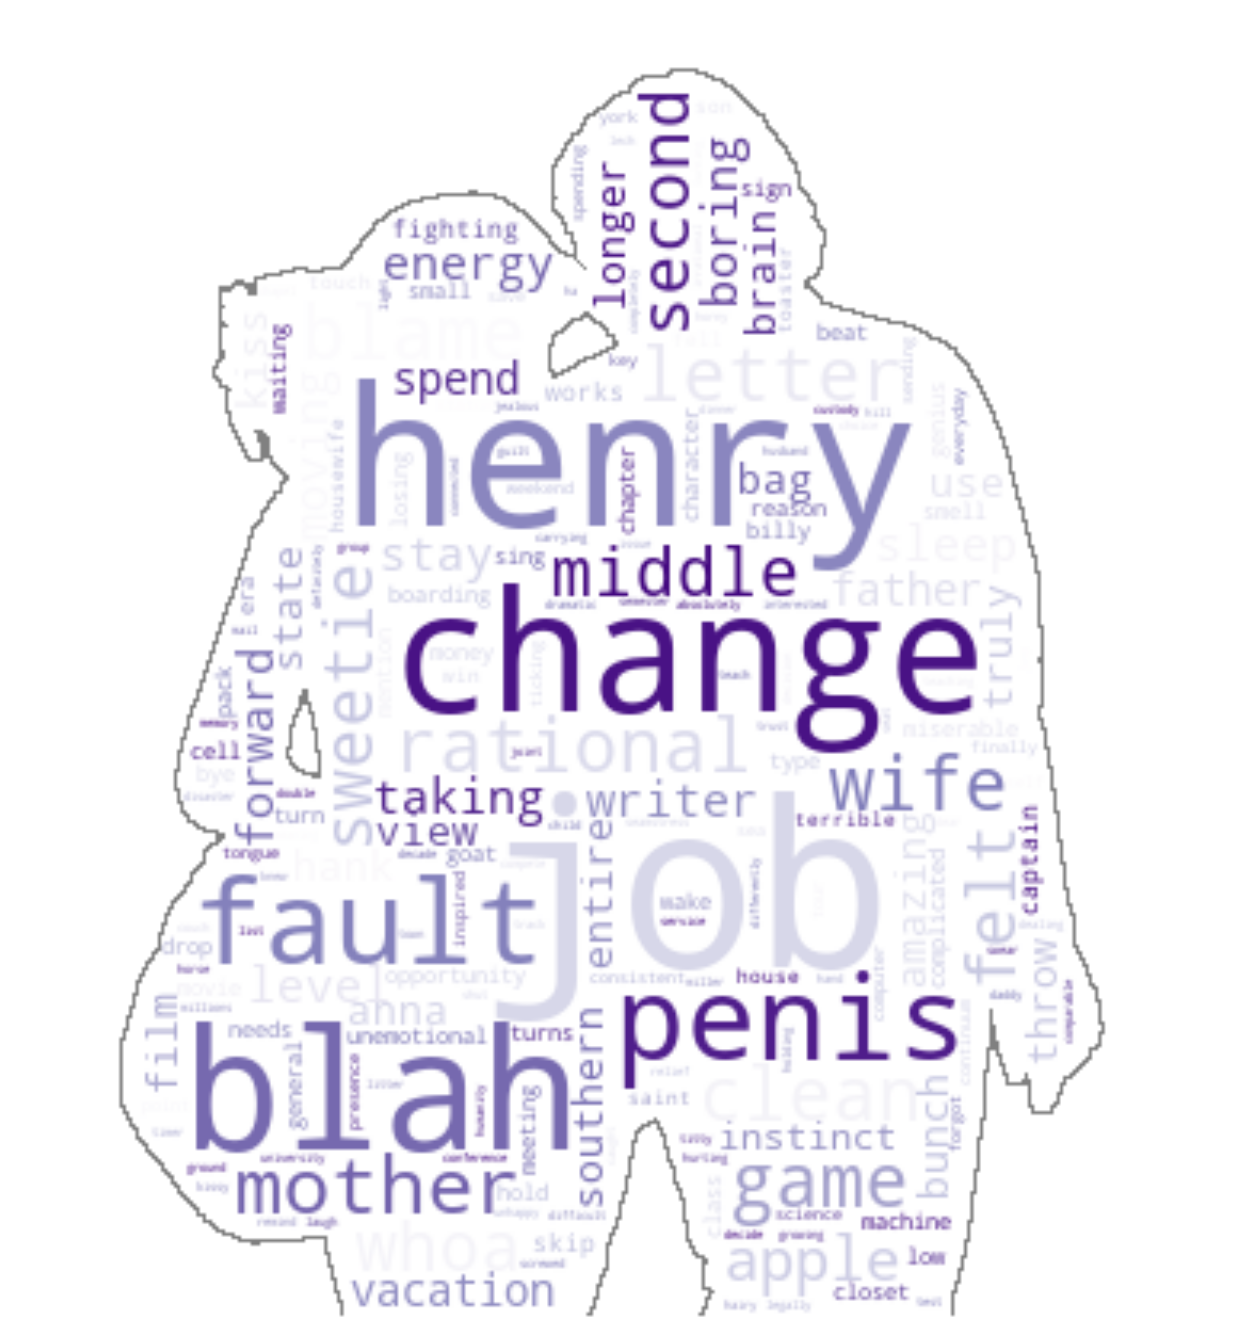

In [105]:
scene = 'midnight'

# create a pandas Series of the most frequent words
text=bow.loc[scene].sort_values(ascending=False)
text_analyze=bow.loc[scene].sort_values(ascending=False).to_dict()

# open the image and use np.array to transform the file to an array
mask=np.array(Image.open('0_data\\before_midnight.png'))

#create and generate our wordcloud object
wordcloud = WordCloud(min_word_length=1,
                      background_color='white',
                      contour_color='gray',
                      mask=mask, 
                      colormap='Purples',
                      contour_width=1).generate_from_frequencies(text_analyze)


#plot
fig, ax = plt.subplots(figsize = (12, 12), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [106]:
fig.savefig('3_output\wordcloud_midnight.png', bbox_inches='tight')

## 2. Sentiment trend

In [107]:
def get_sentiment_trend(df, window_size):
    df = df.reset_index(drop=True)
    
    sentences_list = df['text'].tolist()

    nrc_emo_category = ['fear', 'anger', 'anticip', 'trust', 'surprise', 'positive', 'negative', 'sadness', 'disgust', 'joy']
    nrc_emo = []
    blob_emo = []
    ret_list = []

    for sentence in sentences_list:
        # using Text Blob to get emotions per sentence
        sentence_blob = TextBlob(sentence)
        blob_emo.append(sentence_blob.sentiment[0])

        # using NRCLex to get emotions per sentence
        emo_sent = NRCLex(sentence)
        nrc_emo.append(emo_sent.top_emotions)    

        # change the tuple to dictionary format. This is just for habit convinience, not really necessary
        top_emo_dict = {x[0] : x[1] for x in emo_sent.top_emotions}

        # for each sentence (row), generate a dictionary that has all the emotion categories, and the value of each is zero
        sen_ret_dict = {emo_cat : 0 for emo_cat in nrc_emo_category}

        # loop through all the emotions in a sentence, and change the value of that emotion to what the function returns  
        for emo_cat, emo_val in top_emo_dict.items():
            if emo_cat == 'anticipation':
                emo_cat = 'anticip' # This is to fix the typo returned by NRCLex function

            sen_ret_dict[emo_cat] = emo_val 

        ret_list.append(sen_ret_dict)  
    
    # add blob_emo to dataframe 
    df['blob_emo'] = blob_emo
    
    # add nrc_emo to dataframe
    df['nrc_emo'] = nrc_emo
    
    # add each element in nrc to dataframe
    emo = pd.DataFrame(ret_list)
    df_emo = pd.concat([df, emo], axis=1)
    
    # calcuate nrc sentiment
    df_emo['pos_neg'] = df_emo['positive'] - df_emo['negative']

    # add sentence number
    df_emo = df_emo.reset_index(drop=True)
    df_emo['sen_num'] = df_emo.index
    
    # smoth the sentiment
    df_emo['nrc_rolling'] = df_emo['pos_neg'].rolling(window_size, win_type='triang', center=True).mean()
    df_emo['blob_rolling'] = df_emo['blob_emo'].rolling(window_size, win_type='triang', center=True).mean()
        
    return df_emo 

In [108]:
sunrise_emo = get_sentiment_trend(sunrise, 50)

In [109]:
sunset_emo = get_sentiment_trend(sunset, 50)

In [110]:
midnight_emo = get_sentiment_trend(midnight, 50)

In [111]:
# Wanted palette details
enmax_palette = ["#fea889", "#C2CD23", "#918BC3"]
color_codes_wanted = ['orange', 'green', 'purple']
c = lambda x: enmax_palette[color_codes_wanted.index(x)]

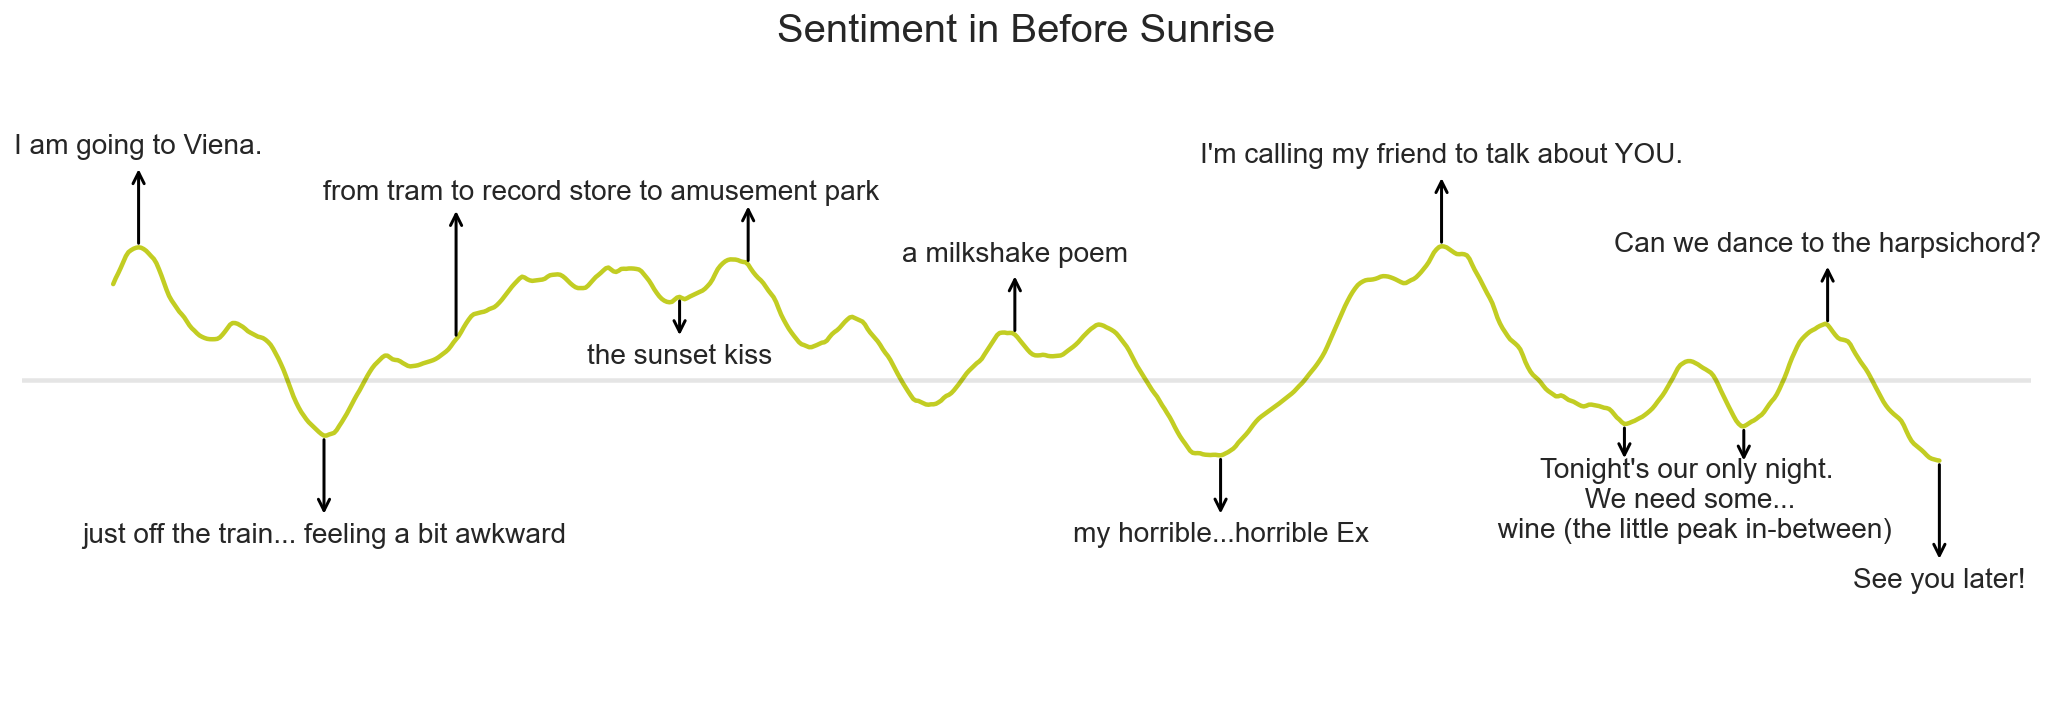

In [112]:
# Plotting pretty figures and avoid blurry images
%config InlineBackend.figure_format = 'retina'

sns.set_context('talk')

sns.set_style('white')
fig, ax = plt.subplots(1, 1, figsize=(18, 6))

ax = sns.lineplot(data=sunrise_emo, x="sen_num", y="nrc_rolling", color=c("green"))
plt.title('Sentiment in Before Sunrise', fontsize=20)
# ax.set(ylabel='nrc sentiment score', xlabel='Timeline')
ax.tick_params(left = True, right = False, labelleft = True, labelbottom = True, bottom = False)
ax.axhline(0, color='black', alpha = 0.1)

ax.set_ylim([-0.3, 0.3])
ax.axis("off")

# add text
def get_y(x):
    return sunrise_emo['nrc_rolling'].iloc[x]

my_font_size = 14

label_list = [
    {
        'text' : 'I am going to Viena.',
        'xy' : (35, get_y(35)),
        'font_size' : my_font_size,
        'xytext' : (0, 50),
        'arrow' : True
    }, 
    {
        'text' : 'just off the train... feeling a bit awkward',
        'xy' : (108, get_y(108)),
        'font_size' : my_font_size,
        'xytext' : (0, -50),
        'arrow' : True        
    },
    {
        'text' : ' ',
        'xy' : (160, get_y(160)), # where the tram scene starts
        'font_size' : my_font_size,
        'xytext' : (0, 75),
        'arrow' : True        
    },    
    {
        'text' : ' ',
        'xy' : (275, get_y(275)), # where the amusement park scene ends
        'font_size' : my_font_size,
        'xytext' : (0, 40),
        'arrow' : True        
    },     
    {
        'text' : 'from tram to record store to amusement park',
        'xy' : (217, get_y(217)), # middle points between 160 and 275
        'font_size' : my_font_size,
        'xytext' : (0, 40),
        'arrow' : False        
    },
    {
        'text' : 'the sunset kiss',
        'xy' : (248, get_y(248)), 
        'font_size' : my_font_size,
        'xytext' : (0, -30),
        'arrow' : True        
    },   
    {
        'text' : 'a milkshake poem',
        'xy' : (380, get_y(380)), 
        'font_size' : my_font_size,
        'xytext' : (0, 40),
        'arrow' : True        
    }, 
    {
        'text' : 'my horrible...horrible Ex',
        'xy' : (461, get_y(461)), 
        'font_size' : my_font_size,
        'xytext' : (0, -40),
        'arrow' : True        
    }, 
    {
        'text' : 'I\'m calling my friend to talk about YOU.',
        'xy' : (548, get_y(548)), 
        'font_size' : my_font_size,
        'xytext' : (0, 45),
        'arrow' : True        
    }, 
    {
        'text' : ' ',
        'xy' : (620, get_y(620)), 
        'font_size' : my_font_size,
        'xytext' : (0, -28),
        'arrow' : True        
    }, 
    {
        'text' : ' ',
        'xy' : (667, get_y(667)), 
        'font_size' : my_font_size,
        'xytext' : (0, -28),
        'arrow' : True        
    }, 
    {
        'text' : 'Tonight\'s our only night. \n We need some... \n wine (the little peak in-between)',
        'xy' : (646, get_y(646)), 
        'font_size' : my_font_size,
        'xytext' : (0, -70),
        'arrow' : False        
    },    
    {
        'text' : 'Can we dance to the harpsichord?',
        'xy' : (700, get_y(700)), 
        'font_size' : my_font_size,
        'xytext' : (0, 40),
        'arrow' : True        
    },     
    {
        'text' : 'See you later!',
        'xy' : (744, get_y(744)), 
        'font_size' : my_font_size,
        'xytext' : (0, -60),
        'arrow' : True        
    },       
    
]

for label_dict in label_list:
        ax.annotate(
        text=label_dict['text'],
        xy=label_dict['xy'], # where the point is located
        xycoords='data', 
        fontsize=label_dict['font_size'], 
        xytext=label_dict['xytext'], # where to move the text relative to the point. 
        textcoords='offset points',  
        arrowprops=dict(arrowstyle='<-', color='black') if label_dict['arrow'] else None, # add arrows
        horizontalalignment='center', # position arrows 
        verticalalignment='center'
    );
        
plt.show()

In [113]:
fig.savefig('3_output\sentiment_timeline_sunrise.png', bbox_inches='tight')

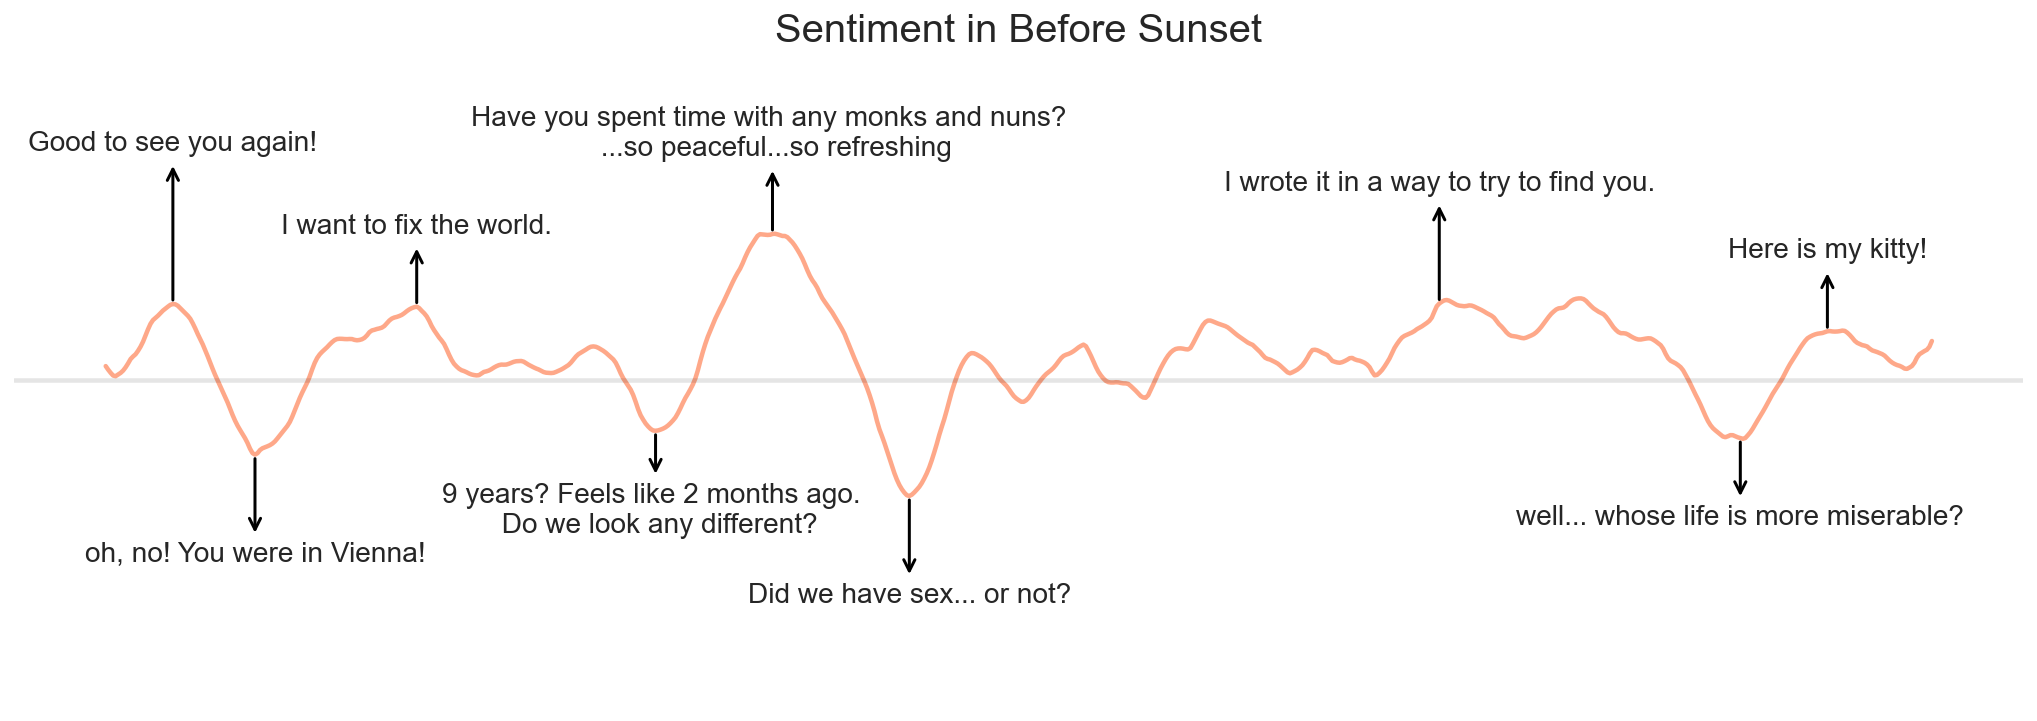

In [114]:
# Plotting pretty figures and avoid blurry images
%config InlineBackend.figure_format = 'retina'

sns.set_context('talk')

sns.set_style('white')
fig, ax = plt.subplots(1, 1, figsize=(18, 6))

ax = sns.lineplot(data=sunset_emo, x="sen_num", y="nrc_rolling", color=c("orange"))
tt = plt.title('Sentiment in Before Sunset', fontsize=20)
# ax.set(ylabel='nrc sentiment score', xlabel='Timeline')
tt = ax.tick_params(left = True, right = False, labelleft = True, labelbottom = True, bottom = False)
tt = ax.axhline(0, color='black', alpha = 0.1)

tt = ax.set_ylim([-0.3, 0.3])
tt = ax.axis("off")

def get_y(x):
    return sunset_emo['nrc_rolling'].iloc[x]

# add text
my_font_size = 14

label_list = [
    {
        'text' : 'Good to see you again!',
        'xy' : (52, get_y(52)),
        'font_size' : my_font_size,
        'xytext' : (0, 80),
        'arrow' : True
    }, 
    {
        'text' : 'oh, no! You were in Vienna!',
        'xy' : (85, get_y(85)),
        'font_size' : my_font_size,
        'xytext' : (0, -50),
        'arrow' : True        
    },
    {
        'text' : 'I want to fix the world.',
        'xy' : (150, get_y(150)), # where the tram scene starts
        'font_size' : my_font_size,
        'xytext' : (0, 40),
        'arrow' : True        
    },    
    {
        'text' : '9 years? Feels like 2 months ago. \n Do we look any different?',
        'xy' : (246, get_y(246)), # where the amusement park scene ends
        'font_size' : my_font_size,
        'xytext' : (0, -40),
        'arrow' : True        
    },     
    {
        'text' : 'Have you spent time with any monks and nuns? \n ...so peaceful...so refreshing',
        'xy' : (293, get_y(293)), # middle points between 160 and 275
        'font_size' : my_font_size,
        'xytext' : (0, 50),
        'arrow' : True        
    },
    {
        'text' : 'Did we have sex... or not?',
        'xy' : (348, get_y(348)), 
        'font_size' : my_font_size,
        'xytext' : (0, -50),
        'arrow' : True        
    },   
    {
        'text' : 'I wrote it in a way to try to find you.',
        'xy' : (561, get_y(561)), 
        'font_size' : my_font_size,
        'xytext' : (0, 60),
        'arrow' : True        
    }, 
    {
        'text' : 'well... whose life is more miserable?',
        'xy' : (682, get_y(682)), 
        'font_size' : my_font_size,
        'xytext' : (0, -40),
        'arrow' : True        
    }, 
    {
        'text' : 'Here is my kitty!',
        'xy' : (717, get_y(717)), 
        'font_size' : my_font_size,
        'xytext' : (0, 40),
        'arrow' : True        
    },       
    
]

for label_dict in label_list:
    tt = ax.annotate(
        text=label_dict['text'],
        xy=label_dict['xy'], # where the point is located
        xycoords='data', 
        fontsize=label_dict['font_size'], 
        xytext=label_dict['xytext'], # where to move the text relative to the point. 
        textcoords='offset points',  
        arrowprops=dict(arrowstyle='<-', color='black') if label_dict['arrow'] else None, # add arrows
        horizontalalignment='center', # position arrows 
        verticalalignment='center'
    );

plt.show()

In [115]:
fig.savefig('3_output\sentiment_timeline_sunset.png', bbox_inches='tight')

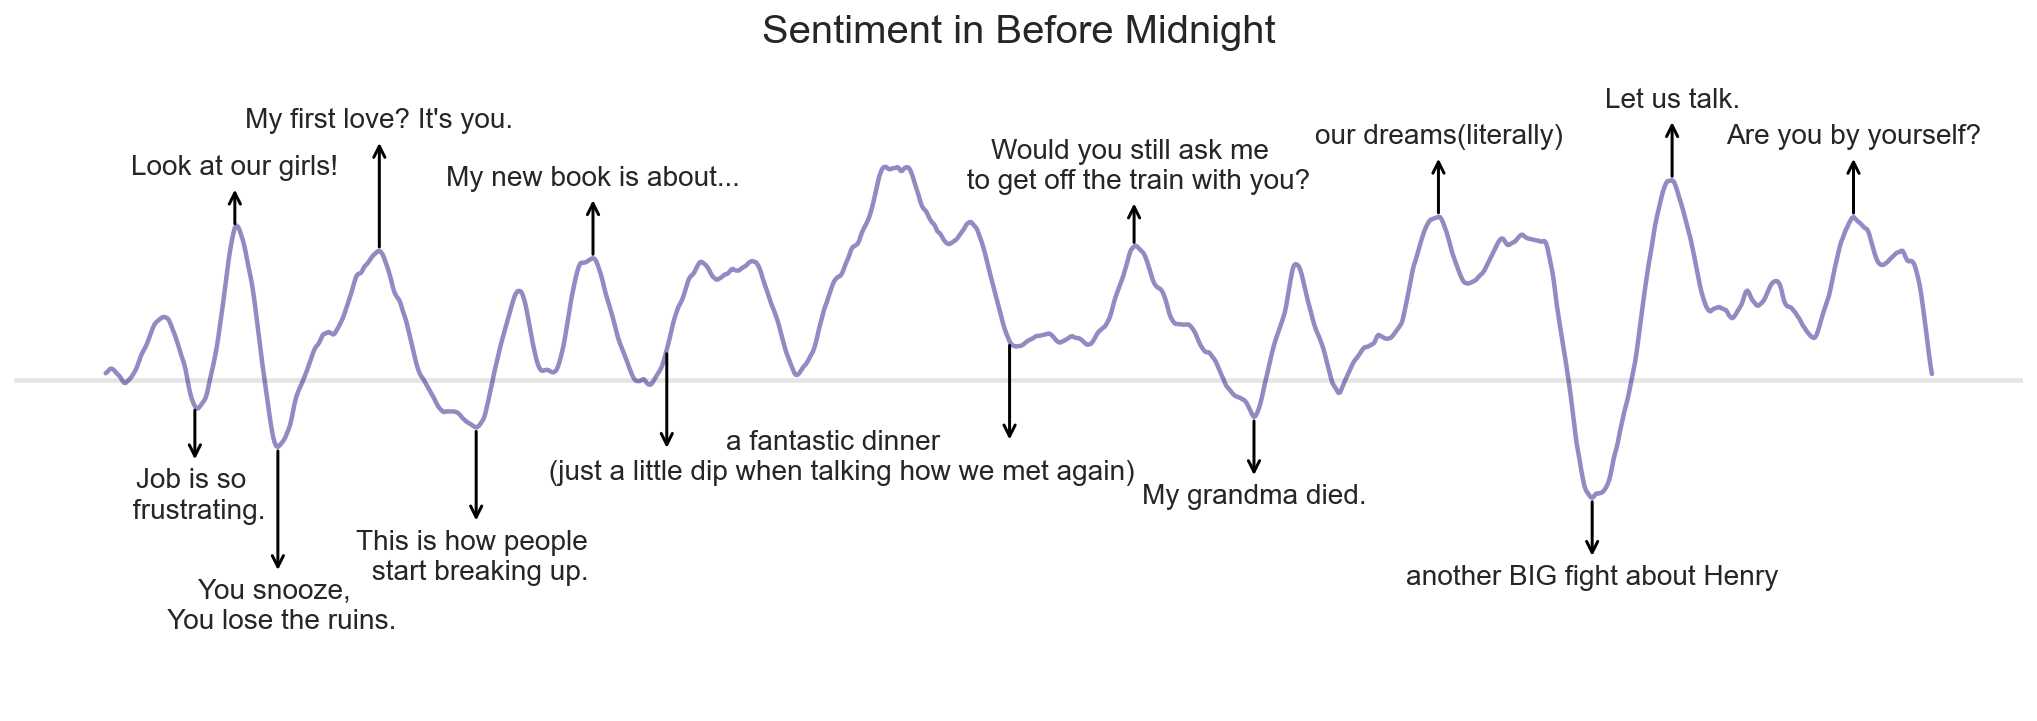

In [116]:
# Plotting pretty figures and avoid blurry images
%config InlineBackend.figure_format = 'retina'

sns.set_context('talk')

sns.set_style('white')
fig, ax = plt.subplots(1, 1, figsize=(18, 6))

ax = sns.lineplot(data=midnight_emo, x="sen_num", y="nrc_rolling", color=c("purple"))
plt.title('Sentiment in Before Midnight', fontsize=20)
# ax.set(ylabel='nrc sentiment score', xlabel='Timeline')
tt = ax.tick_params(left = True, right = False, labelleft = True, labelbottom = True, bottom = False)
tt = ax.axhline(0, color='black', alpha = 0.1)

tt = ax.set_ylim([-0.3, 0.3])
tt = ax.axis("off")

def get_y(x):
    return midnight_emo['nrc_rolling'].iloc[x]

# add text
my_font_size = 14

label_list = [
    {
        'text' : 'Job is so \n frustrating.',
        'xy' : (83, get_y(83)), 
        'font_size' : my_font_size,
        'xytext' : (0, -45),
        'arrow' : True        
    }, 
    {
        'text' : 'Look at our girls!',
        'xy' : (109, get_y(109)), 
        'font_size' : my_font_size,
        'xytext' : (0, 30),
        'arrow' : True        
    },   
    {
        'text' : 'You snooze, \n You lose the ruins.',
        'xy' : (137, get_y(137)), # where the tram scene starts
        'font_size' : my_font_size,
        'xytext' : (0, -80),
        'arrow' : True        
    },  
    {
        'text' : 'My first love? It\'s you.',
        'xy' : (203, get_y(203)), 
        'font_size' : my_font_size,
        'xytext' : (0, 65),
        'arrow' : True        
    },  
    {
        'text' : 'This is how people \n start breaking up.',
        'xy' : (266, get_y(266)),
        'font_size' : my_font_size,
        'xytext' : (0, -65),
        'arrow' : True        
    },
    {
        'text' : 'My new book is about...',
        'xy' : (342, get_y(342)), 
        'font_size' : my_font_size,
        'xytext' : (0, 40),
        'arrow' : True        
    },  
    {
        'text' : ' ',
        'xy' : (390, get_y(390)), # dinner starts
        'font_size' : my_font_size,
        'xytext' : (0, -60),
        'arrow' : True        
    }, 
    {
        'text' : ' ',
        'xy' : (613, get_y(613)), # dinner ends
        'font_size' : my_font_size,
        'xytext' : (0, -60),
        'arrow' : True        
    },   
    {
        'text' : 'a fantastic dinner \n (just a little dip when talking how we met again)',
        'xy' : (501, get_y(501)), 
        'font_size' : my_font_size,
        'xytext' : (0, -90),
        'arrow' : False       
    }, 
    {
        'text' : 'Would you still ask me \n to get off the train with you?',
        'xy' : (694, get_y(694)), 
        'font_size' : my_font_size,
        'xytext' : (0, 40),
        'arrow' : True        
    },  
    {
        'text' : 'My grandma died.',
        'xy' : (772, get_y(772)), # where the amusement park scene ends
        'font_size' : my_font_size,
        'xytext' : (0, -40),
        'arrow' : True        
    },     
    {
        'text' : 'our dreams(literally)',
        'xy' : (892, get_y(892)), 
        'font_size' : my_font_size,
        'xytext' : (0, 40),
        'arrow' : True        
    },   
    {
        'text' : 'another BIG fight about Henry',
        'xy' : (992, get_y(992)),
        'font_size' : my_font_size,
        'xytext' : (0, -40),
        'arrow' : True
    },  
     
    {
        'text' : 'Let us talk.',
        'xy' : (1044, get_y(1044)), 
        'font_size' : my_font_size,
        'xytext' : (0, 40),
        'arrow' : True        
    },  

    {
        'text' : 'Are you by yourself?',
        'xy' : (1162, get_y(1162)), 
        'font_size' : my_font_size,
        'xytext' : (0, 40),
        'arrow' : True        
    }, 
    
]

for label_dict in label_list:
    tt = ax.annotate(
        text=label_dict['text'],
        xy=label_dict['xy'], # where the point is located
        xycoords='data', 
        fontsize=label_dict['font_size'], 
        xytext=label_dict['xytext'], # where to move the text relative to the point. 
        textcoords='offset points',  
        arrowprops=dict(arrowstyle='<-', color='black') if label_dict['arrow'] else None, # add arrows
        horizontalalignment='center', # position arrows 
        verticalalignment='center'
    );

plt.show()

In [117]:
fig.savefig('3_output\sentiment_timeline_midnight.png', bbox_inches='tight')

## 3. Sentiment by charactors

In [26]:
def get_sentiment(df):
    emo_dic = {}
    
    sentences_list =df['text'].tolist()
    
    full_text = ' '.join(sentences_list) # concatenate the list into a large string
    full_text = ' '.join([x for x in full_text.split() if x]) # remove all the duplicated whitespace

    # using Text Blob to get emotions per sentence
    emo_bob = TextBlob(full_text).sentiment
    
    # using NRCLex to get emotions per sentence
    emo_nrc = NRCLex(full_text).affect_frequencies
    
    emo_dic['polarity'] = emo_bob[0]
    emo_dic['subjectivity'] = emo_bob[1]
    
    emo_dic.update(emo_nrc)
    
    return emo_dic

In [27]:
def get_sub_dataframe(df, df_name):
    movie_cha = {}
    
    df_main = df[(df.speaker == 'jesse') | (df.speaker == 'celine')]
    df_jesse = df[(df.speaker == 'jesse')]
    df_celine = df[(df.speaker == 'celine')]
    
    movie_cha[df_name + '_main'] = get_sentiment(df_main)
    movie_cha[df_name + '_jesse'] = get_sentiment(df_jesse)
    movie_cha[df_name + '_celine'] = get_sentiment(df_celine)
    
    return movie_cha

In [28]:
three_movies = pd.concat([sunrise, sunset, midnight])

In [29]:
midnight_combined = pd.DataFrame(get_sub_dataframe(midnight, 'midnight')).T
sunrise_combined = pd.DataFrame(get_sub_dataframe(sunrise, 'sunrise')).T
sunset_combined = pd.DataFrame(get_sub_dataframe(sunset, 'sunset')).T
all_combined = pd.DataFrame(get_sub_dataframe(three_movies, 'all')).T

sentiment = pd.concat([sunrise_combined, sunset_combined, midnight_combined, all_combined])
sentiment['movie_cha'] = sentiment.index

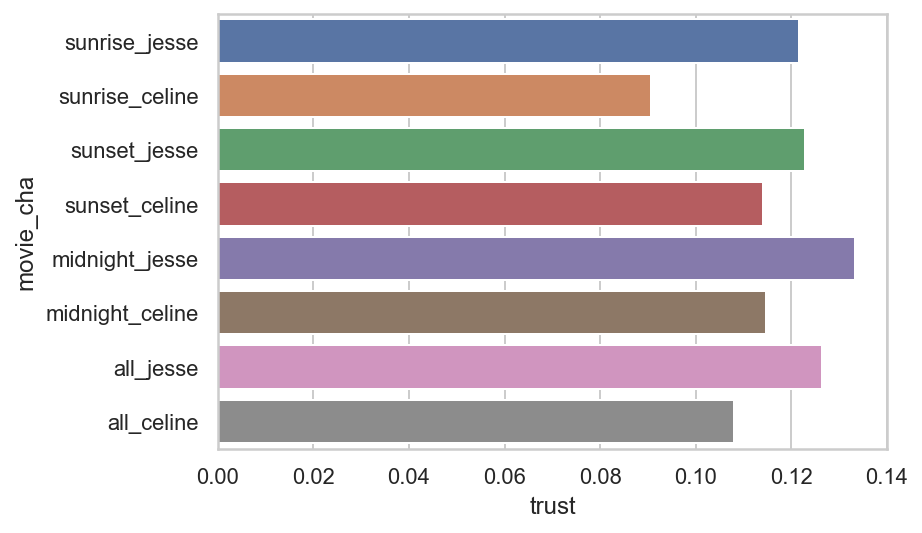

In [30]:
sns.set_theme(style="whitegrid")
# data_display = sentiment[sentiment['movie_cha'].str.contains("main")]
data_display = sentiment[sentiment['movie_cha'].str.contains("jesse") | sentiment['movie_cha'].str.contains("celine") ]
ax = sns.barplot(y="movie_cha", x="trust", data=data_display)

In [31]:
# the three movies reivew very similar personalities for both Jesse and Celine. 
# Thus I aggregate the three movies together when plotting. 
senti = sentiment[(sentiment['movie_cha'] == 'all_jesse') | (sentiment['movie_cha'] == 'all_celine')]
senti = senti.T.iloc[:-1].astype(float)

pos_senti = senti.loc[['anticipation', 'joy', 'trust', 'surprise']]
neg_senti = senti.loc[['disgust', 'anger', 'sadness', 'fear']]

In [32]:
font_color = 'black'
hfont = {'fontname':'BitstreamVeraSans Roman'} # default font
facecolor = 'white'
color_light_red = '#ffbaba'
color_dark_red = '#ff5252'
color_light_blue = '#adcbe3'
color_dark_blue = '#4b86b4'

index_pos = pos_senti.index
index_neg = neg_senti.index
column00 = pos_senti['all_jesse'] *100 
column01 = pos_senti['all_celine'] *100
column10 = neg_senti['all_jesse'] *100
column11 = neg_senti['all_celine'] *100

title0 = 'Jesse'
title1 = 'Celine'

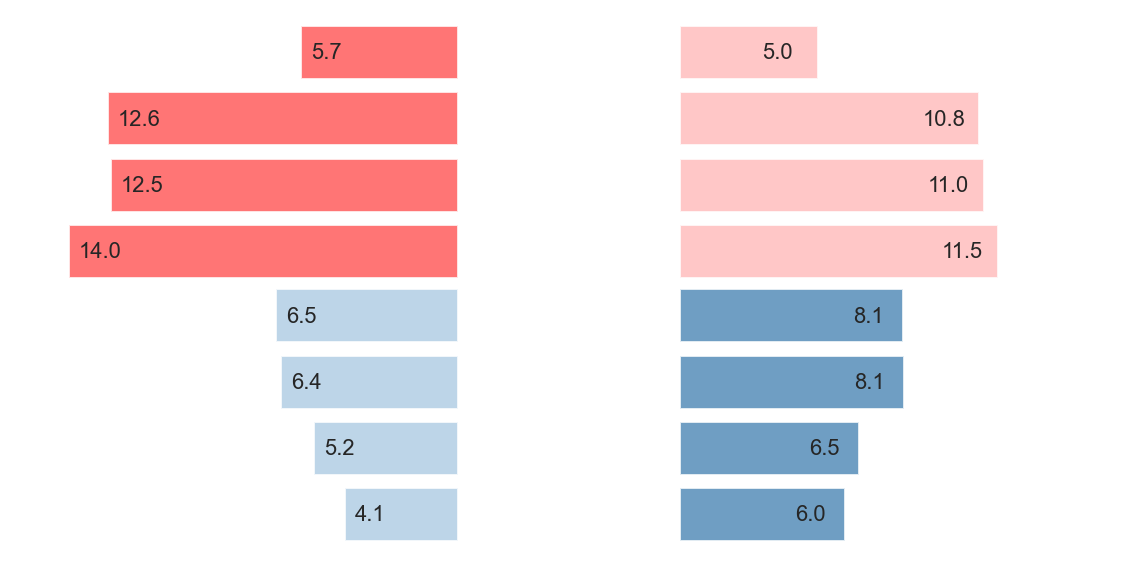

In [34]:
sns.set_style('white')

fig, axes = plt.subplots(figsize=(10,5), facecolor=facecolor, ncols=2, nrows=2)
# fig.tight_layout()

axes[0][0].barh(index_pos, column00, align='center', color=color_dark_red, zorder=10, alpha=0.8)
# axes[0][0].set_title(title0, fontsize=18, pad=15, color='black', **hfont)
axes[0][1].barh(index_pos, column01, align='center', color=color_light_red, zorder=10, alpha=0.8)
# axes[0][1].set_title(title1, fontsize=18, pad=15, color='black', **hfont)

axes[1][0].barh(index_neg, column10, align='center', color=color_light_blue, zorder=10, alpha=0.8)
axes[1][1].barh(index_neg, column11, align='center', color=color_dark_blue, zorder=10, alpha=0.8)

axes[0][0].set_xlim(0, 16)
axes[0][1].set_xlim(0, 16)
axes[1][0].set_xlim(0, 16)
axes[1][1].set_xlim(0, 16)

# If you have positive numbers and want to invert the x-axis of the left plot
axes[0][0].invert_xaxis() 
axes[1][0].invert_xaxis() 

# To show data from highest to lowest
# plt.gca().invert_yaxis()

axes[0][0].axis("off")
axes[0][1].axis("off")
axes[1][0].axis("off")
axes[1][1].axis("off")

for container in axes[0][0].containers:
    axes[0][0].bar_label(container, fontsize=11, label_type='edge', padding=5, fmt='%.1f', zorder=15)

for container in axes[0][1].containers:
    axes[0][1].bar_label(container, fontsize=11, label_type='edge', padding=-28, fmt='%.1f', zorder=15)
    
for container in axes[1][0].containers:
    axes[1][0].bar_label(container, fontsize=11, label_type='edge', padding=5, fmt='%.1f', zorder=15)

for container in axes[1][1].containers:
    axes[1][1].bar_label(container, fontsize=11, label_type='edge', padding=-25, fmt='%.1f', zorder=15)
    
plt.subplots_adjust(wspace=0.5, hspace=-0.05, top=0.85, bottom=0.1, left=0.18, right=0.95)

In [35]:
fig.savefig('3_output\sentiment_by_charater.png', bbox_inches='tight')
# need to add text outside python, which gives better designing results